The Cityscapes Dataset focuses on semantic understanding of urban street scenes. In the provided dataset from bootcamp it contains 12 classes without label names

# Import Libraries

In [1]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.8 MB/s eta 0:00:00


In [2]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Drive Setup

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset Preparation

In [5]:
import shutil

In [6]:
drive_dataset_path = '/content/drive/MyDrive/cv_bootcamp_indonesiaai/project_3/dataset'
drive_model_path = '/content/drive/MyDrive/cv_bootcamp_indonesiaai/project_3/models'

In [7]:
destination_folder = '/content/cityscapes'

In [8]:
shutil.copytree(drive_dataset_path, destination_folder)

'/content/cityscapes'

In [9]:
model_dest_folder = '/content/models'

In [10]:
shutil.copytree(drive_model_path, model_dest_folder)

'/content/models'

In [11]:
# drive.flush_and_unmount()

In [12]:
train_img_path = os.path.join(destination_folder, 'images_train', 'images_prepped_train')
train_annot_path = os.path.join(destination_folder, 'annotations_train', 'annotations_prepped_train')

test_img_path = os.path.join(destination_folder, 'images_test', 'images_prepped_test')
test_annot_path = os.path.join(destination_folder, 'annotations_test', 'annotations_prepped_test')

In [13]:
print(f'total train images: {len(os.listdir(train_img_path))}')
print(f'total train annots: {len(os.listdir(train_annot_path))}')
print(f'total test images: {len(os.listdir(test_img_path))}')
print(f'total test annots: {len(os.listdir(test_annot_path))}')

total train images: 367
total train annots: 367
total test images: 101
total test annots: 101


The total number of train images bigger than total number of train annotations which means there are some train images that doesn't have annotations

In [14]:
def get_classes_annotations(annotation_folder):
    # Initialize a dictionary to store the counts for each class
    class_counts = {}

    # Iterate through each file in the folder
    for filename in os.listdir(annotation_folder):
        if filename.endswith('.png'):  # Assuming images are in PNG format, adjust as needed
            # Load the annotation image
            annotation_path = os.path.join(annotation_folder, filename)
            annotation_image = Image.open(annotation_path)

            # Convert the image to a NumPy array
            annotation_array = np.array(annotation_image)

            # Count occurrences of each unique class value
            unique_classes, counts = np.unique(annotation_array, return_counts=True)

            # Update the class_counts dictionary
            for class_value, count in zip(unique_classes, counts):
                if class_value not in class_counts:
                    class_counts[class_value] = 0
                class_counts[class_value] += count

    # Print the class counts
    for class_value, count in class_counts.items():
        print(f"Class {class_value}: {count} pixels")

    # Print the number of unique classes and the unique class values
    number_of_classes = len(class_counts)
    unique_classes_values = sorted(list(class_counts.keys()))

    print("\nNumber of Unique Classes:", number_of_classes)
    print("Unique Class Values:", unique_classes_values)

In [15]:
get_classes_annotations(train_annot_path)

Class 0: 10682767 pixels
Class 1: 14750079 pixels
Class 2: 623349 pixels
Class 3: 20076880 pixels
Class 4: 2845085 pixels
Class 5: 6166762 pixels
Class 6: 743859 pixels
Class 8: 3719877 pixels
Class 9: 405385 pixels
Class 11: 2503995 pixels
Class 10: 184967 pixels
Class 7: 714595 pixels

Number of Unique Classes: 12
Unique Class Values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [16]:
get_classes_annotations(test_annot_path)

Class 0: 1601620 pixels
Class 1: 4531180 pixels
Class 2: 98499 pixels
Class 3: 5053176 pixels
Class 4: 1521751 pixels
Class 5: 2851125 pixels
Class 6: 155724 pixels
Class 7: 537197 pixels
Class 8: 304716 pixels
Class 9: 113531 pixels
Class 10: 387010 pixels
Class 11: 297271 pixels

Number of Unique Classes: 12
Unique Class Values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


There are imbalanced classes

## Data Cleaning

Let's take a look of train images with no annotations

In [17]:
def get_image_no_annot(imgs_path, annots_path):
    paths = []
    for img_path in os.listdir(imgs_path):
        if img_path not in os.listdir(annots_path):
            paths.append(img_path)
    return paths

In [18]:
no_annot_imgs = get_image_no_annot(train_img_path, train_annot_path)

In [19]:
print(no_annot_imgs)

[]


Seems the train images contains duplicate data

### Remove Duplicates

Remove duplicate images with no annotations

In [20]:
def remove_image_no_annot(imgs_path, no_annot_imgs):
    for img in no_annot_imgs:
        file_path = os.path.join(imgs_path, img)
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"File at {file_path} has been removed.")
        else:
            print(f"File at {file_path} does not exist.")

In [21]:
remove_image_no_annot(train_img_path, no_annot_imgs)

In [22]:
print(f'total train images: {len(os.listdir(train_img_path))}')
print(f'total train annots: {len(os.listdir(train_annot_path))}')
print(f'total test images: {len(os.listdir(test_img_path))}')
print(f'total test annots: {len(os.listdir(test_annot_path))}')

total train images: 367
total train annots: 367
total test images: 101
total test annots: 101


## Load Data

In [23]:
#Resizing images, if needed
SIZE_X = 256
SIZE_Y = 256
n_classes=12 #Number of classes for segmentation

### Direct Load

In [24]:
import cv2
import glob

In [25]:
def get_images(img_paths):
    #Capture training image info as a list
    images = []

    for directory_path in glob.glob(img_paths):
        for img_path in glob.glob(os.path.join(directory_path, "*.png")):
            img = cv2.imread(img_path, 1)
            img = cv2.resize(img, (SIZE_Y, SIZE_X))
            images.append(img)

    #Convert list to array for machine learning processing
    images = np.array(images) * 1./255
    return images

In [26]:
def get_annots(img_paths):
    #Capture training image info as a list
    images = []

    for directory_path in glob.glob(img_paths):
        for img_path in glob.glob(os.path.join(directory_path, "*.png")):
            img = cv2.imread(img_path, 0)
            img = cv2.resize(img, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
            images.append(img)

    #Convert list to array for machine learning processing
    images = np.array(images)
    return images

In [27]:
train_images = get_images(train_img_path)
train_annots = get_annots(train_annot_path)

In [28]:
print(f'train_images: {train_images.shape}')
print(f'train_annots: {train_annots.shape}')

train_images: (367, 256, 256, 3)
train_annots: (367, 256, 256)


In [29]:
test_images = get_images(test_img_path)
test_annots = get_annots(test_annot_path)

In [30]:
print(f'test_images: {test_images.shape}')
print(f'test_annots: {test_annots.shape}')

test_images: (101, 256, 256, 3)
test_annots: (101, 256, 256)


### One Hot Encoding

In [31]:
from keras.utils import to_categorical

In [32]:
def get_categorical_annots(annots):
    masks_input = np.expand_dims(annots, axis=3)
    masks_cat = to_categorical(masks_input, num_classes=n_classes)
    y_cat = masks_cat.reshape((masks_input.shape[0], masks_input.shape[1], masks_input.shape[2], n_classes))
    return y_cat

In [33]:
y_train_cat = get_categorical_annots(train_annots)
y_test_cat = get_categorical_annots(test_annots)

### Class Weights

In [34]:
from sklearn.utils import class_weight

In [35]:
encoded_target = train_annots.flatten()

In [36]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=[0,1,2,3,4,5,6,7,8,9,10,11],
                                                  y=encoded_target)

In [37]:
class_weights

array([ 0.49103854,  0.35784426,  8.39919932,  0.26478814,  1.85447001,
        0.85473691,  7.09864436,  7.38880471,  1.41907148, 13.04489729,
       28.49985544,  2.1209241 ])

If needed, manually defined because already run before to reduce RAM usage

In [ ]:
# class_weights = np.array([ 0.49337632,  0.35815776,  8.44163312,  0.26382973,  1.85541732,
#         0.85605058,  7.1049925 ,  7.39363466,  1.41975514, 13.02422326,
#        28.5191601 ,  2.11419231])
# class_weights

array([ 0.49337632,  0.35815776,  8.44163312,  0.26382973,  1.85541732,
        0.85605058,  7.1049925 ,  7.39363466,  1.41975514, 13.02422326,
       28.5191601 ,  2.11419231])

# Model

In [38]:
import tensorflow as tf
import segmentation_models as sm
import keras.backend as K
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

Segmentation Models: using `tf.keras` framework.


In [39]:
activation='softmax'

LR = 0.0001
optim = Adam(LR)

dice_loss = sm.losses.DiceLoss()
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [40]:
default_callback = ModelCheckpoint(
                filepath=os.path.join(drive_model_path, 'resnet50_unet_segmentation'),
                # save_weights_only=True,
                save_best_only=True,
                verbose=True
            )

callbacks = [default_callback, EarlyStopping(monitor='val_loss', patience=10)]

In [41]:
def get_preprocessed_img(X_train, X_test, backbone='resnet50'):
    preprocess_input1 = sm.get_preprocessing(backbone)

    # preprocess input
    X_train = preprocess_input1(X_train)
    X_test = preprocess_input1(X_test)

    return X_train, X_test

In [42]:
X_train, X_test = get_preprocessed_img(train_images, test_images)

In [43]:
def create_model(backbone='resnet50'):
    # define model
    model = sm.Unet(backbone, encoder_weights='imagenet', classes=n_classes, activation=activation)

    # compile keras model with defined optimozer, loss and metrics
    model.compile(optim, dice_loss, metrics=metrics)

    print(model.summary())

    return model

In [ ]:
unet_resnet50 = create_model()

94592056/94592056 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                           

## Train

In [ ]:
class_weights

array([ 0.49103854,  0.35784426,  8.39919932,  0.26478814,  1.85447001,
        0.85473691,  7.09864436,  7.38880471,  1.41907148, 13.04489729,
       28.49985544,  2.1209241 ])

In [44]:
class_weights_map = {}
for i in range(len(class_weights)):
    class_weights_map[i] = class_weights[i]

class_weights_map

{0: 0.49103854139309294,
 1: 0.3578442627409378,
 2: 8.399199321686341,
 3: 0.2647881411892111,
 4: 1.8544700109209329,
 5: 0.8547369097386731,
 6: 7.0986443587355215,
 7: 7.388804714735638,
 8: 1.4190714823633475,
 9: 13.044897286203657,
 10: 28.499855437219466,
 11: 2.1209241033053727}

In [ ]:
unet_resnet50.compile(optim, dice_loss, metrics=metrics)

In [ ]:
history=unet_resnet50.fit(
    X_train,
    y_train_cat,
    batch_size=4,
    epochs=100,
    verbose=1,
    validation_data=(X_test, y_test_cat),
    callbacks=callbacks,
    class_weight=class_weights_map
    )

Epoch 1/100
92/92 [==============================] - ETA: 0s - loss: 0.8339 - iou_score: 0.1561 - f1-score: 0.2031
Epoch 1: val_loss improved from inf to 0.98248, saving model to /content/drive/MyDrive/cv_bootcamp_indonesiaai/project_3/models/resnet50_unet_segmentation_comb_losses
92/92 [==============================] - 88s 610ms/step - loss: 0.8339 - iou_score: 0.1561 - f1-score: 0.2031 - val_loss: 0.9825 - val_iou_score: 3.3792e-09 - val_f1-score: 3.3792e-09
Epoch 2/100
92/92 [==============================] - ETA: 0s - loss: 0.6897 - iou_score: 0.3382 - f1-score: 0.3993
Epoch 2: val_loss improved from 0.98248 to 0.93867, saving model to /content/drive/MyDrive/cv_bootcamp_indonesiaai/project_3/models/resnet50_unet_segmentation_comb_losses
92/92 [==============================] - 58s 638ms/step - loss: 0.6897 - iou_score: 0.3382 - f1-score: 0.3993 - val_loss: 0.9387 - val_iou_score: 0.0174 - val_f1-score: 0.0295
Epoch 3/100
92/92 [==============================] - ETA: 0s - loss: 0.6

### Evaluation

Load trained model

In [45]:
import tensorflow as tf

In [46]:
def load_model(model_path, custom_objects=None):
    # Load the model
    loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

    # Display the model summary
    loaded_model.summary()

    return loaded_model

In [47]:
# Define custom objects for loading the model
custom_objects = {
    'dice_loss': sm.losses.DiceLoss(),
    'iou_score': sm.metrics.IOUScore(threshold=0.5),
    'f1-score': sm.metrics.FScore(threshold=0.5),
}

In [48]:
unet_resnet50 = load_model(os.path.join(drive_model_path, 'resnet50_unet_segmentation'), custom_objects=custom_objects)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d_18 (ZeroPad  (None, None, None, 3)        0         ['bn_data[0][0]']             
 ding2D)                                                                                          
                                                                                            

In [49]:
unet_resnet50.evaluate(X_test, y_test_cat)

4/4 [==============================] - 16s 1s/step - loss: 0.2643 - iou_score: 0.6258 - f1-score: 0.7300


[0.2642505466938019, 0.6257609128952026, 0.7300031185150146]

In [50]:
def get_predictions(model):
    y_pred=model.predict(X_test)
    y_pred_argmax=np.argmax(y_pred, axis=3)

    return y_pred_argmax

In [51]:
y_pred_argmax = get_predictions(unet_resnet50)

4/4 [==============================] - 2s 202ms/step


In [52]:
#Using built in keras function
from keras.metrics import MeanIoU

In [53]:
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_annots, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

Mean IoU = 0.634338
[[5.926440e+05 2.858000e+03 9.000000e+00 0.000000e+00 0.000000e+00
  1.427600e+04 0.000000e+00 0.000000e+00 2.000000e+00 0.000000e+00
  0.000000e+00 2.506000e+03]
 [6.387000e+03 1.539821e+06 2.260000e+03 2.672000e+03 1.793300e+04
  3.053200e+04 4.739000e+03 2.147300e+04 1.138500e+04 6.769000e+03
  1.791000e+03 8.400300e+04]
 [1.600000e+01 1.817700e+04 4.282000e+03 5.800000e+01 6.270000e+02
  7.542000e+03 3.400000e+01 4.832000e+03 7.400000e+01 2.310000e+02
  1.700000e+01 9.000000e+02]
 [0.000000e+00 2.084000e+03 1.470000e+02 1.874494e+06 1.604500e+04
  1.000000e+00 0.000000e+00 0.000000e+00 4.192000e+03 8.980000e+02
  3.471000e+03 1.717000e+03]
 [0.000000e+00 1.407200e+04 5.700000e+01 1.552600e+04 5.424740e+05
  1.000000e+00 0.000000e+00 2.200000e+01 8.120000e+02 9.470000e+02
  5.930000e+02 2.658000e+03]
 [1.107300e+04 4.518000e+03 1.567000e+03 0.000000e+00 0.000000e+00
  1.048446e+06 1.289000e+03 1.368900e+04 1.000000e+01 1.000000e+00
  2.000000e+00 5.580000e+02]
 [

In [54]:
def get_classes_iou(values, n_classes):
    class_ious = {}
    for i in range(n_classes):
        m = values[i,i]
        n = values[i,i]
        for j in range(n_classes):
            if i != j:
                n += values[i,j]
                n += values[j,i]

        class_ious[i] = m/n

    for k, v in class_ious.items():
        print(f"IoU for class {k} is: {v}")

In [55]:
get_classes_iou(values, n_classes)

IoU for class 0 is: 0.9358029365539551
IoU for class 1 is: 0.8393933773040771
IoU for class 2 is: 0.09442741423845291
IoU for class 3 is: 0.963627278804779
IoU for class 4 is: 0.8800238966941833
IoU for class 5 is: 0.8955397605895996
IoU for class 6 is: 0.42939087748527527
IoU for class 7 is: 0.5878992080688477
IoU for class 8 is: 0.6769457459449768
IoU for class 9 is: 0.4478553533554077
IoU for class 10 is: 0.6031918525695801
IoU for class 11 is: 0.2579582929611206


In [56]:
import random

In [57]:
def show_predictions(model, X, annots, class_names):
    test_img_number = random.randint(0, len(X))
    test_img = X[test_img_number]
    ground_truth = annots[test_img_number]
    test_img_input = np.expand_dims(test_img, 0)
    prediction = model.predict(test_img_input)
    predicted_img = np.argmax(prediction, axis=3)[0, :, :]

    plt.figure(figsize=(14, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:, :, 0], cmap='gray')

    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth, cmap='jet')
    add_colorbar(plt.imshow(ground_truth, cmap='jet'), class_names, ax=plt.gca())

    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, cmap='jet')
    add_colorbar(plt.imshow(predicted_img, cmap='jet'), class_names, ax=plt.gca())

    plt.show()

def add_colorbar(mappable, class_names, ax=None):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    if ax is None:
        ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(mappable, cax=cax, ticks=np.arange(len(class_names)))
    cbar.set_ticklabels(class_names)

In [58]:
cityscapes_classes = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'
]

1/1 [==============================] - 0s 24ms/step


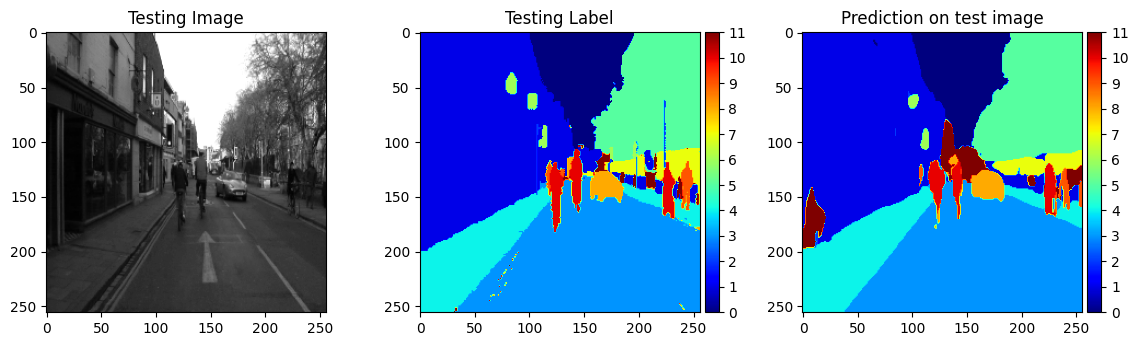

In [62]:
show_predictions(unet_resnet50, X_test, test_annots, cityscapes_classes)

1/1 [==============================] - 0s 25ms/step


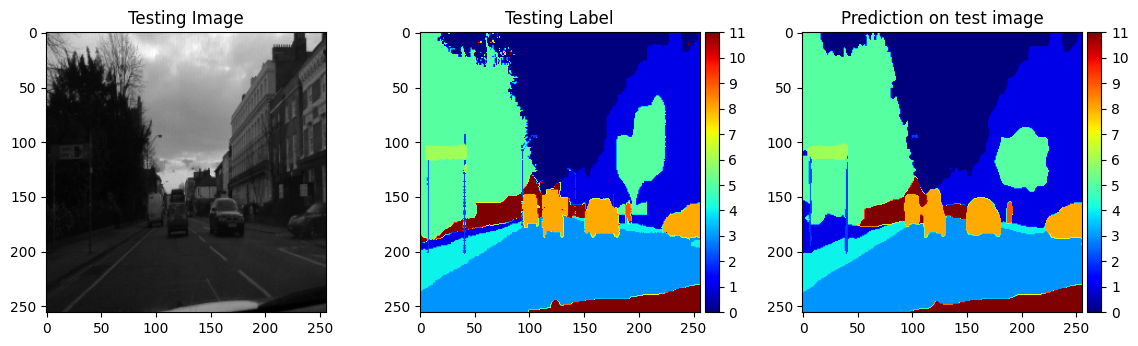

In [60]:
show_predictions(unet_resnet50, X_train, train_annots, cityscapes_classes)

In [61]:
def create_video_from_images(model, X_test, output_video_path):
    # Get the dimensions from the first image in X_test
    height, width, _ = X_test[0].shape

    # Create a VideoWriter object to write the video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change the codec as needed
    out = cv2.VideoWriter(output_video_path, fourcc, 5.0, (width, height))

    # Process each test image in X_test and write to the video
    for frame in X_test:
        # Preprocess the frame (resize, normalize, etc.) to match the input requirements of your model
        original_frame = frame * 255

        # Perform prediction using the model
        input_data = np.expand_dims(frame, axis=0)
        prediction = model.predict(input_data)
        predicted_mask = np.argmax(prediction, axis=3)[0]

        # Convert the predicted mask to a color image
        colored_mask = cv2.applyColorMap((predicted_mask * 21).astype(np.uint8), cv2.COLORMAP_JET)

        # Ensure frame and colored_mask have the same data type
        original_frame = original_frame.astype(colored_mask.dtype)

        # Overlay the colored mask on the original frame
        result_frame = cv2.addWeighted(original_frame, 0.7, colored_mask, 0.3, 0)

        # Write the frame to the video
        out.write(result_frame)

    # Release the VideoWriter object
    out.release()

In [ ]:
create_video_from_images(unet_resnet50, X_test, '/content/test_video.mp4')

1/1 [==============================] - 0s 63ms/step
